In [4]:
from src.environments.market import Market

m = Market("2013-02-12", "2013-02-14", 3)
a = m.reset()
print(a[1,:,1:])

[[6.84014000e+01 6.68928000e+01 6.78542000e+01 1.58168416e+08]
 [6.92771000e+01 6.76071000e+01 6.85614000e+01 1.29029425e+08]
 [6.89114000e+01 6.68205000e+01 6.68428000e+01 1.51829363e+08]]


In [35]:
a,b,c = m.step()
print(a[1,:,:], b[1,:,:], c, sep='\n')
print(m.next_step, m.step_to_date())

[[6.77142000e+01 6.84014000e+01 6.68928000e+01 6.78542000e+01
  1.58168416e+08]
 [6.80714000e+01 6.92771000e+01 6.76071000e+01 6.85614000e+01
  1.29029425e+08]
 [6.85014000e+01 6.89114000e+01 6.68205000e+01 6.68428000e+01
  1.51829363e+08]]
[[6.80714000e+01 6.92771000e+01 6.76071000e+01 6.85614000e+01
  1.29029425e+08]
 [6.85014000e+01 6.89114000e+01 6.68205000e+01 6.68428000e+01
  1.51829363e+08]
 [6.67442000e+01 6.76628000e+01 6.61742000e+01 6.67156000e+01
  1.18721995e+08]]
False
1 2013-02-12


(17, 755, 5)


<Figure size 432x288 with 0 Axes>

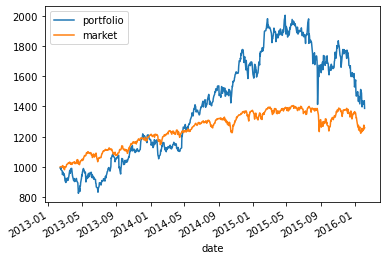

In [3]:
from src.environments.portfolio import Portfolio
import numpy as np

p = Portfolio("2013-02-12", "2016-02-05", 3, continuous=False)
print(p.market.data.shape)

p.reset()
while True:
    #action = np.random.rand(17)
    #action = action / action.sum()
    action = np.zeros(17)
    action[1] = 1
    a,b,c,d = p.step(action)
    if c:
        break

p.render()

[*********************100%***********************]  1 of 1 completed
(17, 755, 5)


<Figure size 432x288 with 0 Axes>

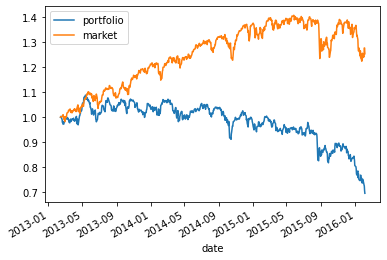

In [1]:
from src.environments.portfolio_end import PortfolioEnd
import numpy as np

p = PortfolioEnd("2013-02-13", "2016-02-05", 4, continuous=False)
print(p.market.data.shape)

p.reset()
while True:
    action = p.action_space.sample()
    action /= action.sum()
    #action = np.zeros(17)
    #action[1] = 1
    a,b,c,d = p.step(action)
    if c:
        break

p.render()

[*********************100%***********************]  1 of 1 completed


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chyyivan (mldlproj1gr2). Use `wandb login --relogin` to force relogin


Begin eval!


<Figure size 432x288 with 0 Axes>

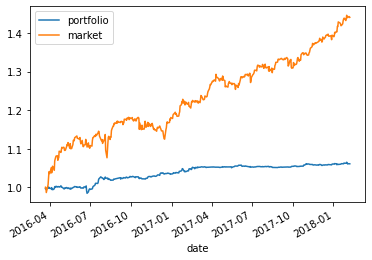

In [1]:
import argparse
import wandb
from src.environments.portfolio_end import PortfolioEnd
from src.ddpg.ddpg import DDPG


def main(params):

    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', default=42, type=int, help='')
    parser.add_argument('--save_model_path', type=str, default=None, help='path to save model')
    parser.add_argument('--model_name', type=str, default=None, help='name of the model')

    parser.add_argument('--start_train', type=str, default="2013-03-22", help='starting date of training data')
    parser.add_argument('--end_train', type=str, default="2016-02-05", help='end date date of training data')
    parser.add_argument('--start_test', type=str, default="2016-03-22", help='starting date of testing data')
    parser.add_argument('--end_test', type=str, default="2018-02-07", help='end date of testing data')
    parser.add_argument('--window_length', default=30, type=int, help='window length')
    parser.add_argument('--stock_names', type=str, default=None, help='name of stocks in the market')
    parser.add_argument('--trading_cost', default=0.002, type=float, help='trading cost')
    parser.add_argument('--continuous', dest='continuous', default=False, action='store_true',
                        help='True to include continuous market assumption, False otherwise')

    parser.add_argument('--num_episodes', default=500, type=int, help='number of episodes to train for')
    parser.add_argument('--eval_steps', default=5, type=int, help='how many episodes for every evaluation step')
    parser.add_argument('--batch_size', default=64, type=int, help='minibatch size')
    parser.add_argument('--tau', default=0.001, type=float, help='moving average for target network')
    parser.add_argument('--gamma', default=0.99, type=float, help='')
    parser.add_argument('--buffer_size', default=100000, type=int, help='buffer size')
    parser.add_argument('--lr_actor', default=0.0001, type=float, help='actor learning rate')
    parser.add_argument('--lr_critic', default=0.001, type=float, help='critic learning rate')

    args = parser.parse_args(params)

    wandb.login()
    with wandb.init(project="thesis", entity="mldlproj1gr2", config=vars(args), mode="disabled") as run:
        config = wandb.config

        env_train = PortfolioEnd(config.start_train, config.end_train, config.window_length, config.stock_names, config.trading_cost, config.continuous)
        env_test = PortfolioEnd(config.start_test, config.end_test, config.window_length, config.stock_names, config.trading_cost, config.continuous)

        ddpg = DDPG(env_train, env_test, config)

        #ddpg.train(run)
        ddpg.load_actor_model('./checkpoints_ddpg/ddpg_ep499.pth')
        ddpg.eval(mode = 'test',render = True)


if __name__ == '__main__':
    params = [
        '--save_model_path', './checkpoints_ddpg',
        '--model_name', 'ddpg',
    ]
    main(params)

In [10]:
from src.environments.portfolio_end import PortfolioEnd
import numpy as np
from src.ddpg.actor import Actor
from src.ddpg.critic import Critic
import torch

p = PortfolioEnd("2013-02-13", "2016-02-05", 4, continuous=False)
a1,a2 = p.reset()
#a1 = np.transpose(a1, (2,0,1))
a1 = torch.from_numpy(a1)
a2 = torch.from_numpy(a2)

#a1 = torch.stack((a1,a1))
#a2 = torch.stack((a2,a2))

actor = Actor(3, 4)
actor.double()
out = actor(a1, a2)

action = np.zeros(17)
action[1] = 1
action = torch.from_numpy(action)

#action = torch.stack((action, action))

critic = Critic(3, 17, 4)
critic.double()
out2 = critic(a1, a2, action)

In [2]:
import numpy as np

a = np.array([2,3,4,5])
a/a[0]

array([1. , 1.5, 2. , 2.5])

In [18]:
aa = [(1,2,3), (4,5,6)]
for a in aa:
    print(*a, 0)

1 2 3 0
4 5 6 0


(750.0, 2000.0)

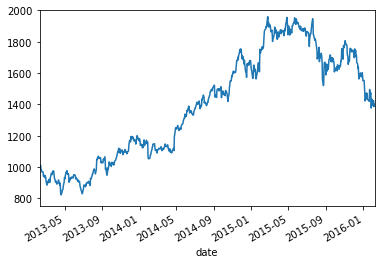

In [4]:
import pandas as pd

a = pd.read_csv('data/AAPL_data.csv')
a['date'] = pd.to_datetime(a['date'], format='%Y-%m-%d')
a.set_index('date', inplace=True)
a['close'] = a['close'].apply(lambda x : x / a.iloc[0]['close'] * 1000)
ax = a['close'].plot()
ax.set_xlim(pd.Timestamp('2013-02-08'), pd.Timestamp('2016-02-07'))
ax.set_ylim(750, 2000)

In [1]:
from src.environments.portfolio import Portfolio

p = Portfolio("2013-02-12", "2016-02-05", 3, continuous=False)

obs = p.reset()
print(obs[1,2,3])
obs[1,2,3] = 1
print(p.market.data[1,2,3])

[*********************100%***********************]  1 of 1 completed
66.8428
66.8428


In [1]:
from src.environments.portfolio_end import PortfolioEnd

p = PortfolioEnd("2013-02-12", "2016-02-05", 3, continuous=False)
p.observation_space

[*********************100%***********************]  1 of 1 completed


Box(-inf, inf, (16, 3, 3), float32)

In [7]:
import torch
a = torch.rand(2)
a.reshape((2,1)).shape

torch.Size([2, 1])